# Estimating covariance kernels from functional fragments 

### Import necessary modules. All useful functions are in $\texttt{functions.py}$. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import svd
from functions import *
from get_estimated_covariance import *
import scipy.stats
from scipy.interpolate import SmoothBivariateSpline
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Defining the parameters of the data following Scenario A in the paper:
- $n$: number of generated samples
- $r$: rank of the covariance kernel
- $N$: size of the observation grid
- $\delta$: maximum length of the fragments
- $\delta_2$: effective length
- $t$: observation grid
- $sds$: coefficients in the kernel's Mercer decomposition 

In [2]:
n = 200
r = 3
N = 50
delta = 0.8
delta2 = 0.7
t = np.linspace(0,1,N)
sds = np.array([1.5,0.55,0.02]).reshape(r,1)

### Defining the mean function $\mu$, here $\mu(t)=t^2$ 

In [3]:
def mu(t):
    return t**2

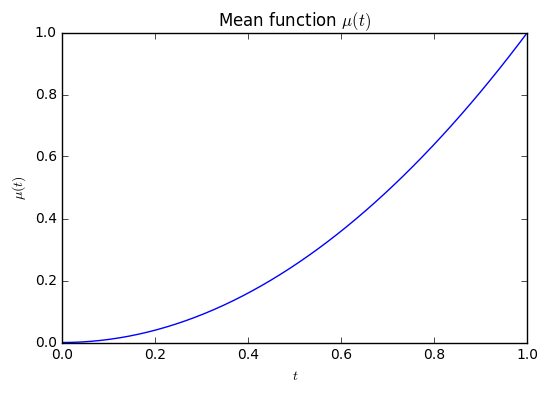

In [4]:
plt.plot(t,mu(t))
plt.title('Mean function $\mu(t)$')
plt.xlabel('$t$')
plt.ylabel('$\mu(t)$')

### Defining the basis functions of $\mathbb{L}^2[0,1]$:
The function $g(x,n) = sin(2 n \pi x)$ is the $n$-th basis function ($g(x,0)=1$).

In [5]:
def g(x,n):
    if n == 0:
        return np.array([1]* len(x))
    else:
        return np.sin(2*n * np.pi * x)

### Defining the random functions:
The random function $X$ is defined by $$X(t) = \sum_{k=1}^r \xi_k g(t,k),$$ where $\xi_k \sim \mathcal{N}(0,\sigma_k^2)$ are independent. 

In [6]:
def X(t,rv):
    return np.sum(np.multiply(np.repeat(rv,N).reshape(r,N),np.array([g(t,i) for i in range(r)])),axis = 0)

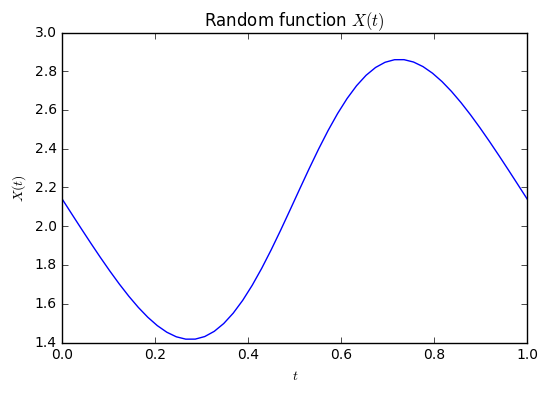

In [7]:
plt.plot(t,X(t,np.random.multivariate_normal(np.zeros(r),np.diag(sds.reshape((-1,))))))
plt.title('Random function $X(t)$')
plt.xlabel('$t$')
plt.ylabel('$X(t)$')

### Generating the covariance kernel $K(\cdot,\cdot)$:

In [8]:
realK = get_real_cov(sds,N,g,t)

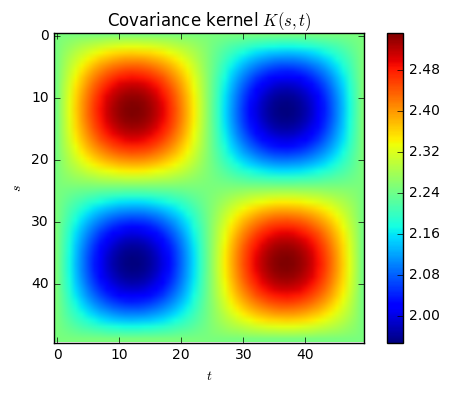

In [9]:
plt.imshow(realK)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Covariance kernel $K(s,t)$')

### Generating the data set $\{X_i\}_{i=1}^n \stackrel{iid}{\sim} X$ 

In [10]:
data = generate_data(n, r, t, X, mu, sds)

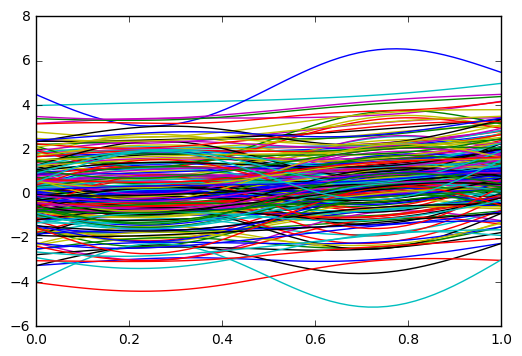

In [11]:
for i in range(n):
    plt.plot(t,data[i])

### Defining the bounds for the fragments: 

In [12]:
bounds, bounds2 = get_bounds(delta=delta, N=N, n=n)

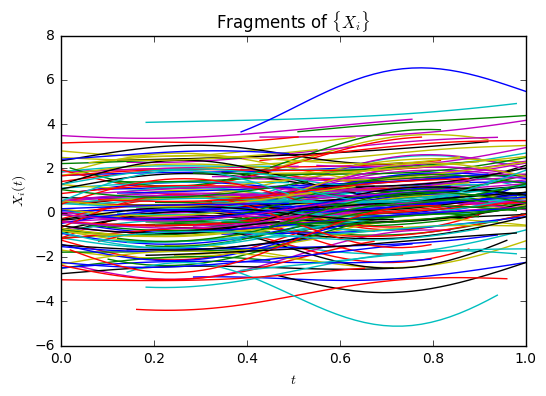

In [13]:
for i in range(n):
    plt.plot(t[bounds[i][0]:bounds[i][1]],data[i][bounds[i][0]:bounds[i][1]])
plt.title('Fragments of $\{X_i\}$')
plt.xlabel('$t$')
plt.ylabel('$X_i(t)$')

### Computing the estimated mean from the fragments:

In [14]:
estmu = [hmu(data,i,bounds) for i in range(N)]

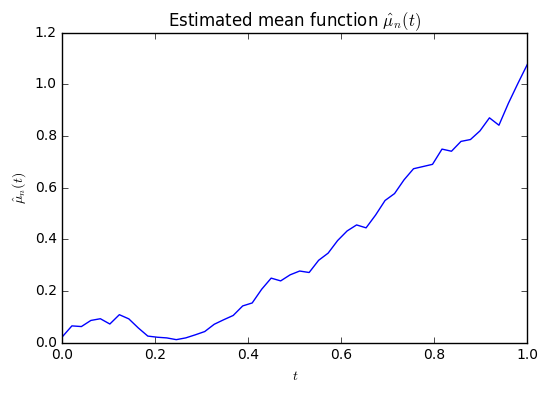

In [15]:
plt.plot(t,estmu)
plt.title('Estimated mean function $\hat{\mu}_n(t)$')
plt.xlabel('$t$')
plt.ylabel('$\hat{\mu}_n(t)$')

### Computing the estimated covariance from the fragments:

In [16]:
trunc_cov = get_trunc_cov(data,bounds2)

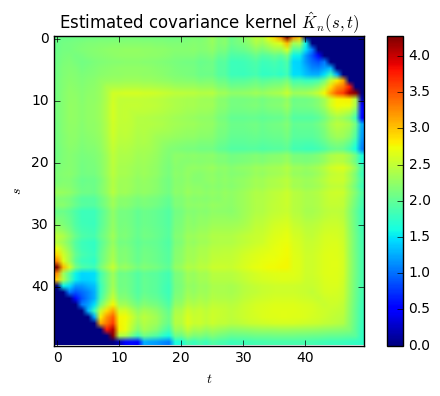

In [17]:
plt.imshow(trunc_cov)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Estimated covariance kernel $\hat{K}_n(s,t)$')

#### Truncating extreme values for better visualisation 

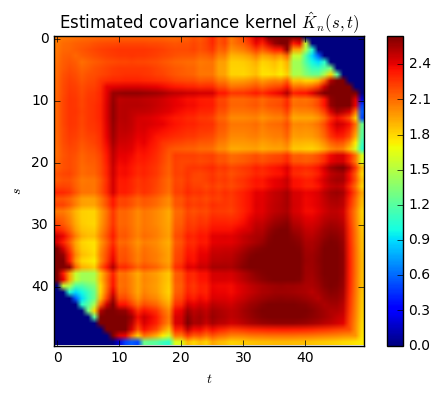

In [18]:
thresh = np.percentile(trunc_cov,95)
trunc_cov_ex = np.copy(trunc_cov)
trunc_cov_ex[trunc_cov_ex>thresh] = thresh
plt.imshow(trunc_cov_ex)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Estimated covariance kernel $\hat{K}_n(s,t)$')

### Recovering the covariance kernel using matrix completion with the true rank 

In [19]:
P = get_P(N,delta2)
tmp = dog(r,P,trunc_cov)[1].reshape((N,-1))
est = tmp @ tmp.T

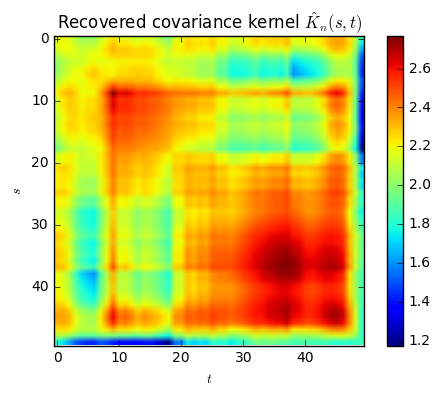

In [20]:
plt.imshow(est)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Recovered covariance kernel $\hat{K}_n(s,t)$')

### Recovered vs True kernel

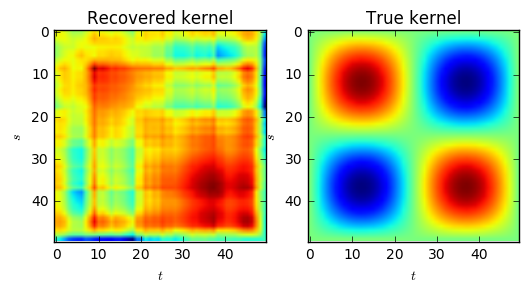

In [21]:
plt.subplot(1, 2, 1)
plt.imshow(est)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Recovered kernel')

plt.subplot(1, 2, 2)
plt.imshow(realK)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('True kernel')

In [22]:
score = np.linalg.norm(realK-est)/np.linalg.norm(realK)
print('The relative error is ' + str(score))

The relative error is 0.0879511866814


### Smoothing the estimated covariance matrix for aesthetic reasons 

The relative error w.r.t. the smoothed estimated is 0.0481987632064


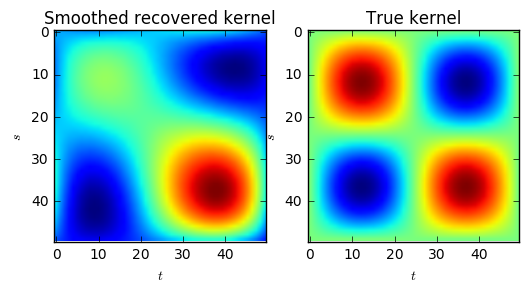

In [23]:
smooth_est = smooth_matrix(est,t)
plt.subplot(1, 2, 1)
plt.imshow(smooth_est)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Smoothed recovered kernel')

plt.subplot(1, 2, 2)
plt.imshow(realK)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('True kernel')

score = np.linalg.norm(realK-smooth_est)/np.linalg.norm(realK)
print('The relative error w.r.t. the smoothed estimated is ' + str(score))

### Finding the optimal rank for the matrix completion 

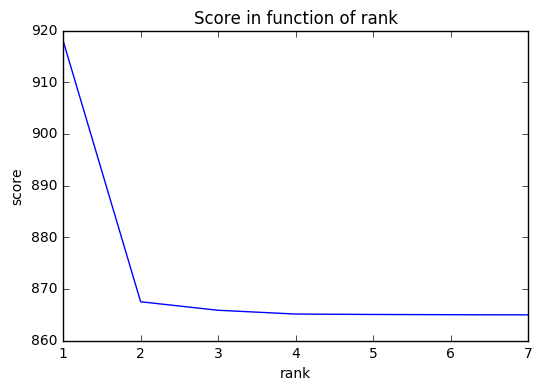

In [24]:
maxr = 8
plt.plot(np.arange(1,maxr), [dog(i,P,trunc_cov)[0] for i in range(1,maxr)])
plt.title('Score in function of rank')
plt.xlabel('rank')
plt.ylabel('score')

## Same thing with Scenario B 

In [27]:
n = 200
r = 3
N = 50
delta = 0.5
delta2 = 0.4
t = np.linspace(0,1,N)
sds = np.array([1.5,0.55,0.02]).reshape(r,1)

In [28]:
def mu(t):
    return t**2

In [29]:
def g(x,n):
    if n == 0:
        return scipy.stats.norm.pdf(x, loc = 0.5, scale = 0.6)
    elif n == 1:
        return scipy.stats.norm.pdf(x, loc = 0.2, scale = 0.25)
    elif n == 2:
        return scipy.stats.norm.pdf(x, loc = 0.8, scale = 0.2)
    else:
        print('Not defined')

In [30]:
def X(t,rv):
    return np.sum(np.multiply(np.repeat(rv,N).reshape(r,N),np.array([g(t,i) for i in range(r)])),axis = 0)

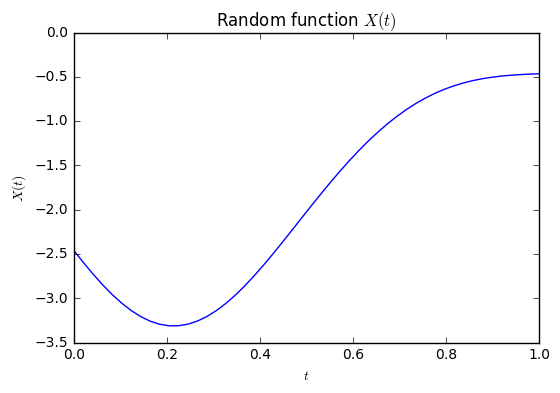

In [31]:
plt.plot(t,X(t,np.random.multivariate_normal(np.zeros(r),np.diag(sds.reshape((-1,))))))
plt.title('Random function $X(t)$')
plt.xlabel('$t$')
plt.ylabel('$X(t)$')

In [32]:
realK = get_real_cov(sds,N,g,t)

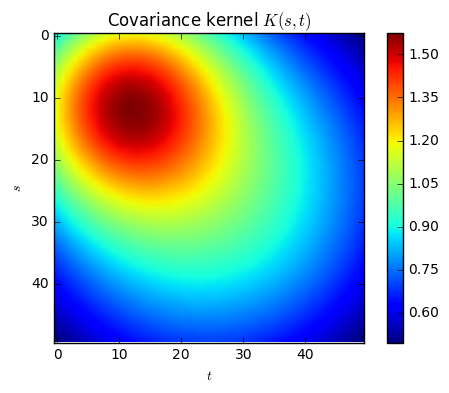

In [33]:
plt.imshow(realK)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Covariance kernel $K(s,t)$')

In [34]:
data = generate_data(n, r, t, X, mu, sds)

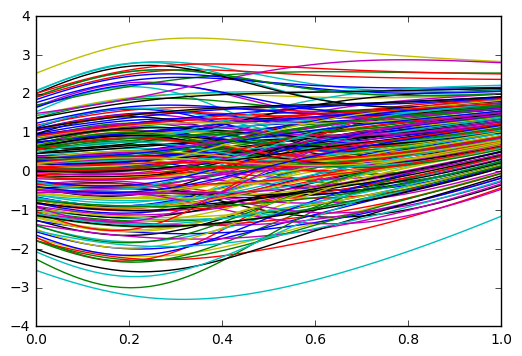

In [35]:
for i in range(n):
    plt.plot(t,data[i])

In [36]:
bounds, bounds2 = get_bounds(delta=delta, N=N, n=n)

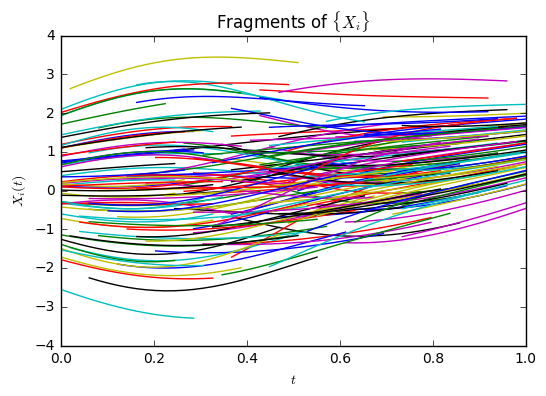

In [37]:
for i in range(n):
    plt.plot(t[bounds[i][0]:bounds[i][1]],data[i][bounds[i][0]:bounds[i][1]])
plt.title('Fragments of $\{X_i\}$')
plt.xlabel('$t$')
plt.ylabel('$X_i(t)$')

In [38]:
estmu = [hmu(data,i,bounds) for i in range(N)]

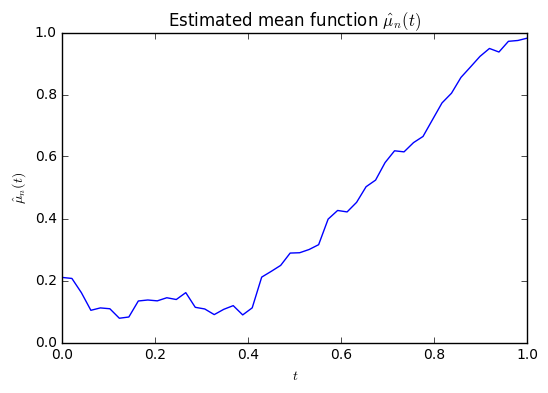

In [39]:
plt.plot(t,estmu)
plt.title('Estimated mean function $\hat{\mu}_n(t)$')
plt.xlabel('$t$')
plt.ylabel('$\hat{\mu}_n(t)$')

In [40]:
trunc_cov = get_trunc_cov(data,bounds2)

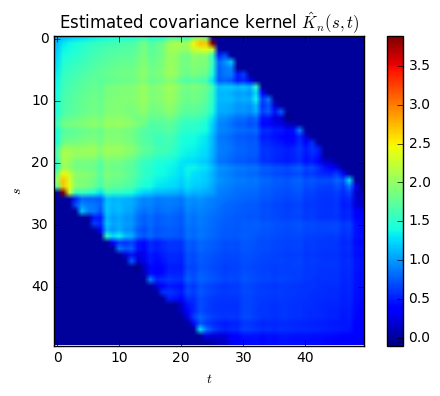

In [41]:
plt.imshow(trunc_cov)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Estimated covariance kernel $\hat{K}_n(s,t)$')

#### Truncating extreme values for better visualisation 

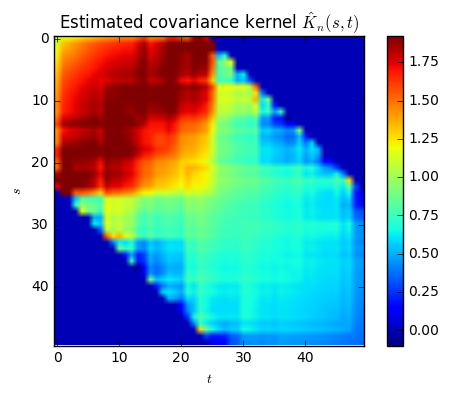

In [42]:
thresh = np.percentile(trunc_cov,95)
trunc_cov_ex = np.copy(trunc_cov)
trunc_cov_ex[trunc_cov_ex>thresh] = thresh
plt.imshow(trunc_cov_ex)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Estimated covariance kernel $\hat{K}_n(s,t)$')

In [43]:
P = get_P(N,delta2)
tmp = dog(r,P,trunc_cov)[1].reshape((N,-1))
est = tmp @ tmp.T

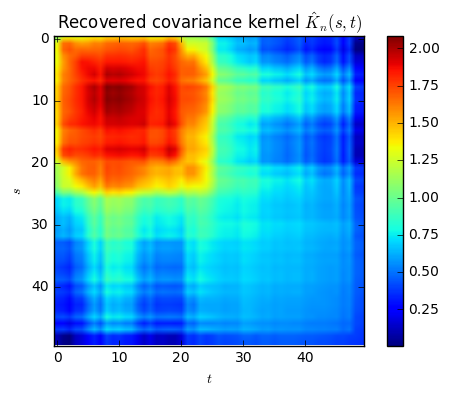

In [44]:
plt.imshow(est)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Recovered covariance kernel $\hat{K}_n(s,t)$')

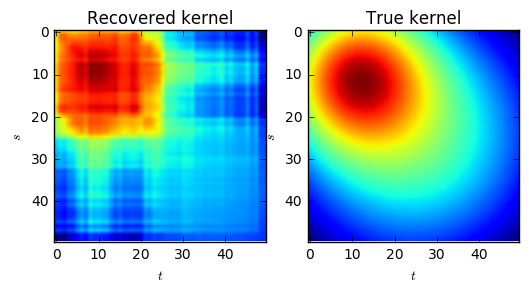

In [45]:
plt.subplot(1, 2, 1)
plt.imshow(est)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Recovered kernel')

plt.subplot(1, 2, 2)
plt.imshow(realK)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('True kernel')

In [46]:
score = np.linalg.norm(realK-est)/np.linalg.norm(realK)
print('The relative error is ' + str(score))

The relative error is 0.279998770231


The relative error w.r.t. the smoothed estimated is 0.246223351153


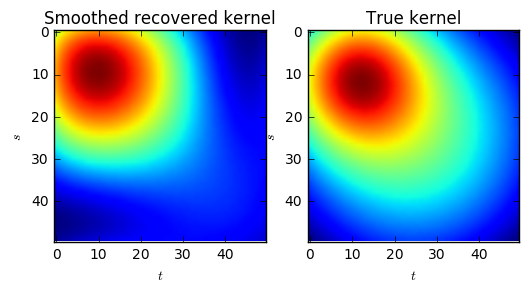

In [47]:
smooth_est = smooth_matrix(est,t)
plt.subplot(1, 2, 1)
plt.imshow(smooth_est)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Smoothed recovered kernel')

plt.subplot(1, 2, 2)
plt.imshow(realK)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('True kernel')

score = np.linalg.norm(realK-smooth_est)/np.linalg.norm(realK)
print('The relative error w.r.t. the smoothed estimated is ' + str(score))

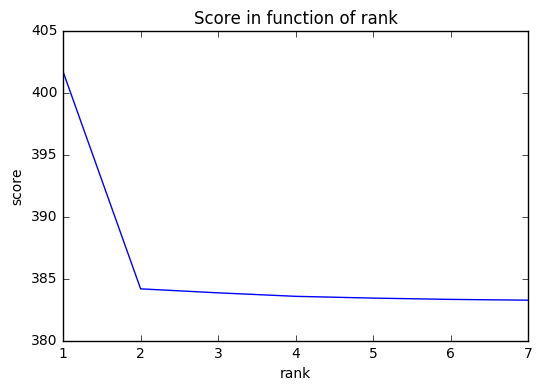

In [48]:
maxr = 8
plt.plot(np.arange(1,maxr), [dog(i,P,trunc_cov)[0] for i in range(1,maxr)])
plt.title('Score in function of rank')
plt.xlabel('rank')
plt.ylabel('score')